### Movie genres analysis

Dataset downloaded from: https://www.kaggle.com/jrobischon/wikipedia-movie-plots

In [77]:
import warnings
warnings.filterwarnings("ignore")

# nltk
from nltk.stem import LancasterStemmer
from nltk.corpus import wordnet
import nltk

# data visualisation
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import pandas as pd
import pylab as pl
import math
import numpy as np
%matplotlib inline

# data wrangling
import re

In [78]:
df = pd.read_csv('wiki_movie_plots_deduped.csv')

In [79]:
df.head(10)

,Release Year,Title,Origin/Ethnicity,Director,Cast,Genre,Wiki Page,Plot
0,1901,Kansas Saloon Smashers,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/Kansas_Saloon_Sm...,"A bartender is working at a saloon, serving dr..."
1,1901,Love by the Light of the Moon,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/Love_by_the_Ligh...,"The moon, painted with a smiling face hangs ov..."
2,1901,The Martyred Presidents,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/The_Martyred_Pre...,"The film, just over a minute long, is composed..."
3,1901,"Terrible Teddy, the Grizzly King",American,Unknown,NaN,unknown,"https://en.wikipedia.org/wiki/Terrible_Teddy,_...",Lasting just 61 seconds and consisting of two ...
4,1902,Jack and the Beanstalk,American,"George S. Fleming, Edwin S. Porter",NaN,unknown,https://en.wikipedia.org/wiki/Jack_and_the_Bea...,The earliest known adaptation of the classic f...
5,1903,Alice in Wonderland,American,Cecil Hepworth,May Clark,unknown,https://en.wikipedia.org/wiki/Alice_in_Wonderl...,"Alice follows a large white rabbit down a ""Rab..."
6,1903,The Great Train Robbery,American,Edwin S. Porter,NaN,western,https://en.wikipedia.org/wiki/The_Great_Train_...,The film opens with two bandits breaking into ...
7,1904,The Suburbanite,American,Wallace McCutcheon,NaN,comedy,https://en.wikipedia.org/wiki/The_Suburbanite,The film is about a family who move to the sub...
8,1905,The Little Train Robbery,American,Edwin Stanton Porter,NaN,unknown,https://en.wikipedia.org/wiki/The_Little_Train...,The opening scene shows the interior of the ro...
9,1905,The Night Before Christmas,American,Edwin Stanton Porter,NaN,unknown,https://en.wikipedia.org/wiki/The_Night_Before...,Scenes are introduced using lines of the poem....


In [80]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34886 entries, 0 to 34885
Data columns (total 8 columns):
Release Year        34886 non-null int64
Title               34886 non-null object
Origin/Ethnicity    34886 non-null object
Director            34886 non-null object
Cast                33464 non-null object
Genre               34886 non-null object
Wiki Page           34886 non-null object
Plot                34886 non-null object
dtypes: int64(1), object(7)
memory usage: 2.1+ MB


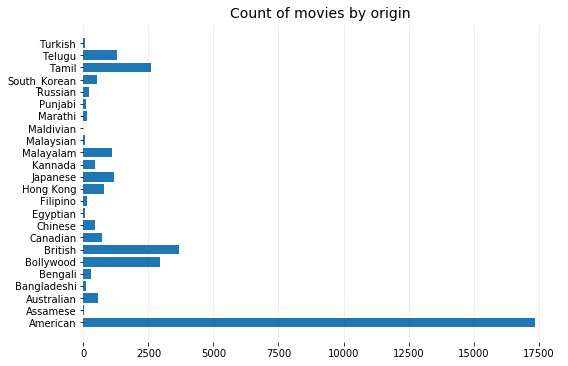

In [89]:
fig, ax = plt.subplots(figsize=(8,5))
plt.barh(y=df['Origin/Ethnicity'].value_counts().index,
         width=df['Origin/Ethnicity'].value_counts().values, )
plt.tight_layout()
ax.grid(c='red', alpha=0.1, axis='x')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.set_title('Count of movies by origin', fontsize=14);

In [76]:
df = df[df['Origin/Ethnicity'] == 'American']

# Cleaning "Genre" column

In [17]:
sum(df['Genre'] == 'unknown')

398

In [18]:
# first remove missing values
df = df[(df['Genre'] != 'unknown') & (df['Genre'] != '')]

In [19]:
# How many unique genre values there are in the dataset?
df['Genre'].nunique()

770

In [20]:
df['Genre'].value_counts()

drama                                                     3549
comedy                                                    3059
western                                                    855
horror                                                     782
action                                                     495
thriller                                                   481
adventure                                                  442
crime drama                                                414
musical                                                    386
science fiction                                            355
film noir                                                  343
romantic comedy                                            322
crime                                                      274
mystery                                                    238
animation                                                  232
war                                                    

In [22]:
df['Genre'].unique()[18:50]

array(['adventure serial', 'epic', 'historical', 'comedy short',
       'comedy, western', 'biography', 'action adventure',
       'western drama', 'short comedy', 'comedy–drama', 'romantic drama',
       'mystery', 'crime drama', 'romance',
       'sexual hygiene/exploitation film', 'comedy drama', 'war drama',
       'spy', 'romantic comedy', 'propaganda', 'ww1 propaganda', 'biopic',
       'animated series', 'drama romance', 'melodrama', 'period drama',
       'swashbuckler', 'romance drama', 'drama, adventure',
       'crime comedy', 'documentary', 'comedy western'], dtype=object)

In [23]:
# How many genre values have less than 10 occurencies?
sum(df['Genre'].value_counts() == 1)

464

We have 464 genres, that appear just one time in the dataframe. Based on results of `value_counts()` function, most of them could be grouped together, but because the values are free text, they are very incoherent. We need to apply some data cleaning.

### NLTK approach

My first thought was to implement some more automatic approach using nltk library. 

Steps: 
* First I extract the group, where more than one word describes genre and keep only nouns. My assumption is that for e.g. `short action` or `historical romance` the adjective only adds the context, while the noun is the major genre for the movie. I remove `short` and `historical` from the description.
* Next, if there are more nouns in genre description left, e.g. `comedy drama` I take only the first one. This is a simplification I'm choosing to make, with the assumption that first genre is most fitted.
* Lastly, having a single word in each genre row, I group them by their stemming. E.g. I will be able to match `animated` and `animation` or `romance` and `romantic`.



In [24]:
lancaster = LancasterStemmer()

In [25]:
print(lancaster.stem("romantic"))

rom


In [26]:
print(lancaster.stem("romance"))

rom


In [27]:
# split genre description containing more than 1 word into a list
df['nltk_cleaned'] =  df['Genre'].apply(lambda x: re.split(' |,|-|/', x))

In [28]:
df.head()

,Release Year,Title,Origin/Ethnicity,Director,Cast,Genre,Wiki Page,Plot,nltk_cleaned
6,1903,The Great Train Robbery,American,Edwin S. Porter,NaN,western,https://en.wikipedia.org/wiki/The_Great_Train_...,The film opens with two bandits breaking into ...,[western]
7,1904,The Suburbanite,American,Wallace McCutcheon,NaN,comedy,https://en.wikipedia.org/wiki/The_Suburbanite,The film is about a family who move to the sub...,[comedy]
10,1906,Dream of a Rarebit Fiend,American,Wallace McCutcheon and Edwin S. Porter,NaN,short,https://en.wikipedia.org/wiki/Dream_of_a_Rareb...,The Rarebit Fiend gorges on Welsh rarebit at a...,[short]
11,1906,From Leadville to Aspen: A Hold-Up in the Rockies,American,Francis J. Marion and Wallace McCutcheon,NaN,short action/crime western,https://en.wikipedia.org/wiki/From_Leadville_t...,The film features a train traveling through th...,"[short, action, crime, western]"
12,1906,Kathleen Mavourneen,American,Edwin S. Porter,NaN,short film,https://en.wikipedia.org/wiki/Kathleen_Mavourn...,Irish villager Kathleen is a tenant of Captain...,"[short, film]"


In [29]:
# change to array to speed up the transformations
array = np.array(df[['Release Year', 'nltk_cleaned']])

In [30]:
array.shape

(16979, 2)

In [31]:
array[0]

array([1903, list(['western'])], dtype=object)

In [32]:
# first step, make sure genre is only one noun
for i in range(len(array)):
    if len(array[i][1]) > 1:
        for element in array[i][1]:
            try:
                if nltk.pos_tag([element])[0][1] != 'NN':
                    array[i][1].remove(element)
            except IndexError:
                continue
    array[i][1] = array[i][1][0]

In [33]:
array[:20]

array([[1903, 'western'],
       [1904, 'comedy'],
       [1906, 'short'],
       [1906, 'action'],
       [1906, 'film'],
       [1907, 'biographical'],
       [1907, 'comedy'],
       [1907, 'comedy'],
       [1908, 'drama'],
       [1908, 'drama'],
       [1908, 'comedy'],
       [1908, 'adventure'],
       [1908, 'drama'],
       [1908, 'western'],
       [1909, 'drama'],
       [1909, 'drama'],
       [1909, 'drama'],
       [1910, 'drama'],
       [1910, 'comedy'],
       [1910, 'drama']], dtype=object)

In [34]:
df2 = pd.DataFrame(array)

In [35]:
df2['stem'] = df2[1].apply(lambda x: lancaster.stem(x))

In [36]:
df2.head(10)

,0,1,stem
0,1903,western,western
1,1904,comedy,comedy
2,1906,short,short
3,1906,action,act
4,1906,film,film
5,1907,biographical,biograph
6,1907,comedy,comedy
7,1907,comedy,comedy
8,1908,drama,dram
9,1908,drama,dram


In [37]:
df2['stem'].nunique()

117

In [38]:
df2['stem'].value_counts()

comedy          4300
dram            4043
hor              885
western          856
crim             804
act              761
sci              625
thriller         511
adv              501
anim             454
mus              390
film             372
war              329
mystery          255
rom              247
famy             224
biograph         217
fantasy          185
                 111
short            109
suspens           96
ser               73
superhero         57
docu              55
spy               48
hist              30
dramedy           29
melodram          26
mocku             22
disast            22
                ... 
box                1
road               1
comedy–drama       1
murd               1
sil                1
sem                1
soc                1
pow                1
imax               1
lgbt               1
compil             1
surv               1
biogtaph           1
stud               1
family.            1
satir              1
footbal      

In [39]:
df2 = df2[df2['stem'] != '']

In [40]:
sum(df2['stem'].value_counts() == 1)

46

In [41]:
df2.reset_index(inplace=True)

In [42]:
popular_nltk_genres = df2['stem'].value_counts()[:20].index
df2 = df2[df2['stem'].isin(popular_nltk_genres)]

In [43]:
stem_dict = {}
for i in range(len(df2.index)):
    if df2.iloc[i]['stem'] not in stem_dict.keys():
        stem_dict[df2.iloc[i]['stem']] = [df2.iloc[i][1]]
    else:
        stem_dict[df2.iloc[i]['stem']].append(df2.iloc[i][1])
    

In [44]:
stem_dict.keys()

dict_keys(['western', 'comedy', 'short', 'act', 'film', 'biograph', 'dram', 'adv', 'fantasy', 'hor', 'crim', 'mystery', 'rom', 'war', 'thriller', 'mus', 'anim', 'sci', 'suspens', 'famy'])

In [45]:
for key in stem_dict.keys():
    if len(stem_dict[key]) > 1:
        stem_dict[key] = stem_dict[key][0]

In [46]:
df2['stem_genre'] = df2['stem'].apply(lambda x: stem_dict[x])

In [47]:
df2 = df2.groupby([0, 'stem_genre'], as_index=False).count()

In [48]:
df2.drop(['index', 'stem'], inplace=True, axis=1)
df2.columns = ['Release year', 'stem_genre', 'stem_count']

In [49]:
df2.head()

,Release year,stem_genre,stem_count
0,1903,western,1
1,1904,comedy,1
2,1906,action,1
3,1906,film,1
4,1906,short,1


### Manual approach

The nltk approach was a bit complicated, it required moving the operations to numpy arrays, as computations on pandas DataFrame were too heavy. Was it necessary? Actually scanning throught the values that appear in the genre column made me think that a simple lambda function would suffice to extract most popular genres. It seemed simple enough as I know the scope of possible movie genres fairly well. Let's see and compare it against nltk approach. I will use the measure of the number of values that appear only once after cleaning. For nltk it was down from 464 to 46.

Things I noticed that could provide a simple fix for most popular columns:
* group all anime in one category (e.g. change `anime fantasy` to simple `anime`)
* group all kinds of sci-fi spellings into one
* group animated movies (`animated` to `animation`)
* group romance movies (`romantic` to `romace`)
* split columns like `comedy-drama` or `horror/action` and extracting only the first genre mentioned. My assumption is that the first is the most descriptive in general. I need high level genres and I decided this is the way to go.


In [50]:
re.split('-|/|,', 'comedy/drama')[0]

'comedy'

In [51]:
df['manually_cleaned'] = df['Genre'].apply(lambda x: 'anime' if 'anime' in x.lower() else
                                         ('sci-fi' if 'science-fiction' in x.lower() else
                                         ('sci-fi' if 'science fiction' in x.lower() else 
                                         ('animation' if 'animated' in x.lower() else 
                                         ('romance' if 'romantic' in x.lower() else 
                                          (re.split(' |-|/|,', x)[0] if len(re.split(' |-|/|,', x)) > 1
                                          and re.split(' |-|/|,', x)[0] != 'sci' else x))))))

In [52]:
df['manually_cleaned'].nunique()

149

In [53]:
df['manually_cleaned'].value_counts()

drama                        3953
comedy                       3757
western                       910
horror                        868
crime                         801
action                        739
sci-fi                        629
animation                     627
romance                       616
musical                       574
adventure                     493
thriller                      492
film                          343
war                           328
mystery                       255
family                        217
biography                     201
fantasy                       177
suspense                       96
serial                         71
superhero                      57
documentary                    55
short                          51
historical                     48
spy                            48
dramedy                        29
melodrama                      26
black                          24
sports                         23
mockumentary  

In [54]:
sum(df['manually_cleaned'].value_counts() == 1)

64

### Compare top genres with movie count from 2 ways of data cleaning

In [55]:
# from manual cleaning
popular_genres = df['manually_cleaned'].value_counts()[:20].index
popular_genres

Index(['drama', 'comedy', 'western', 'horror', 'crime', 'action', 'sci-fi',
       'animation', 'romance', 'musical', 'adventure', 'thriller', 'film',
       'war', 'mystery', 'family', 'biography', 'fantasy', 'suspense',
       'serial'],
      dtype='object')

In [56]:
df3 = df[df['manually_cleaned'].isin(popular_genres)]

In [57]:
df3 = df3.groupby(['Release Year', 'manually_cleaned'])[['Title']].count()

In [58]:
df3.reset_index(inplace=True)

In [59]:
df3 = df3.pivot_table(index='Release Year', columns='manually_cleaned', values='Title')

In [60]:
df3.fillna(0, inplace=True)

In [61]:
df3.head()

manually_cleaned,action,adventure,animation,biography,comedy,crime,drama,family,fantasy,film,horror,musical,mystery,romance,sci-fi,serial,suspense,thriller,war,western
Release Year,,,,,,,,,,,,,,,,,,,,
1903,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1904,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1907,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1908,0.0,1.0,0.0,0.0,1.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1909,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


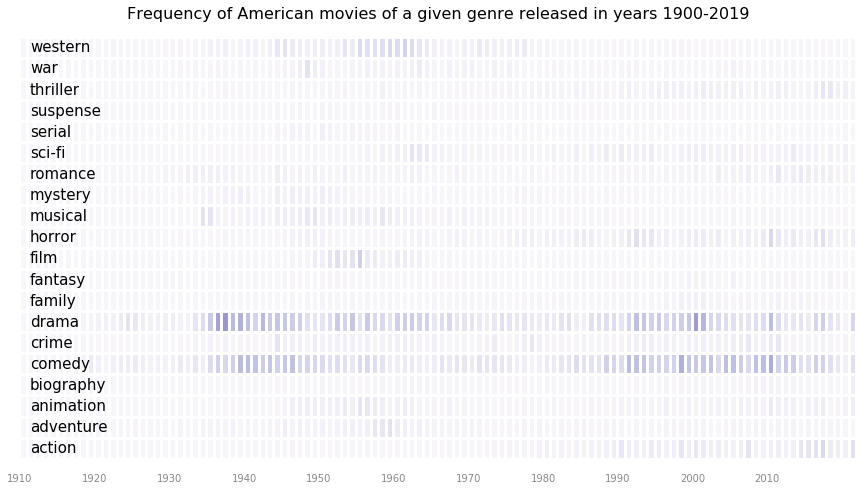

In [90]:
genre, decade = np.mgrid[:df3.shape[0]+1, :df3.shape[1]+1]
fig, ax = pl.subplots(figsize=(15, 8))
# ax.set_aspect("equal")
pl.pcolormesh(genre ,decade , df3.values, cmap='Purples', edgecolor='w', linewidth=2, vmin=-10, vmax=200)
pl.xlim(0, df3.shape[0])

# y axis
ax.yaxis.set_major_locator(MaxNLocator(20))
ax.set_yticklabels(df3.columns, fontsize=15, fontdict={'horizontalalignment':'left'})
y_loc = ax.get_yticks()
ax.set_yticks(y_loc + 0.6)
ax.tick_params(axis='y', direction='in', pad=-10, colors='black', width=20)

# x axis
ax.xaxis.set_major_locator(MaxNLocator(12))
ax.set_xticklabels([x for x in df3.index if x % 10 == 0])
ax.tick_params(axis='x', pad=10, labelcolor='#878787')


# remove frame
for spine in plt.gca().spines.values():
    spine.set_visible(False)
ax.tick_params(top='off', bottom='off', left='off', right='off', labelleft='on', labelbottom='on')

ax.set_title('Frequency of American movies of a given genre released in years 1900-2019', fontsize=16);

In [63]:
# from nlth approach
df2 = df2.pivot_table(index='Release year', columns='stem_genre', values='stem_count')
df2.fillna(0, inplace=True)
df2.head()

stem_genre,action,adventure,animation,biographical,comedy,crime,drama,family,fantasy,film,horror,musical,mystery,romance,science,short,suspense,thriller,war,western
Release year,,,,,,,,,,,,,,,,,,,,
1903,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1904,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1906,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1907,0.0,0.0,0.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1908,0.0,1.0,0.0,0.0,1.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


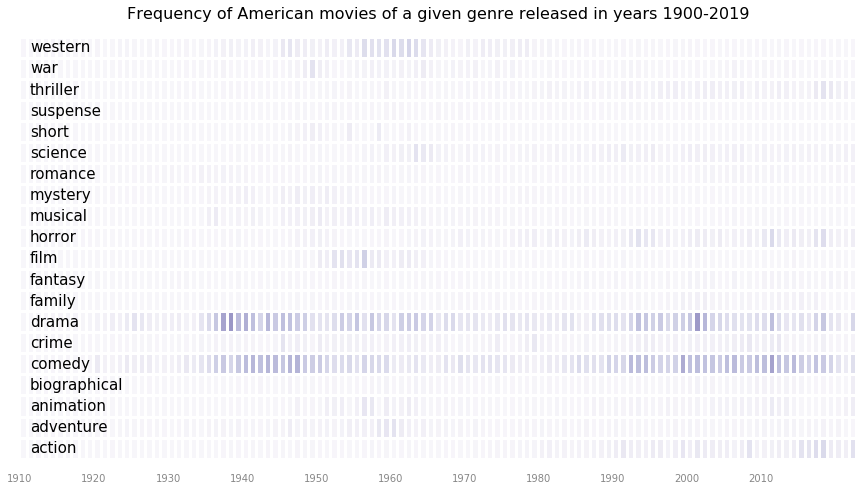

In [91]:
genre, decade = np.mgrid[:df2.shape[0]+1, :df2.shape[1]+1]
fig, ax = pl.subplots(figsize=(15, 8))
# ax.set_aspect("equal")
pl.pcolormesh(genre ,decade , df2.values, cmap='Purples', edgecolor='w', linewidth=2, vmin=-10, vmax=200)
pl.xlim(0, df2.shape[0])

# y axis
ax.yaxis.set_major_locator(MaxNLocator(20))
ax.set_yticklabels(df2.columns, fontsize=15, fontdict={'horizontalalignment':'left'})
y_loc = ax.get_yticks()
ax.set_yticks(y_loc + 0.6)
ax.tick_params(axis='y', direction='in', pad=-10, colors='black', width=20)

# x axis
ax.xaxis.set_major_locator(MaxNLocator(12))
ax.set_xticklabels([x for x in df2.index if x % 10 == 0])
ax.tick_params(axis='x', pad=10, labelcolor='#878787')


# remove frame
for spine in plt.gca().spines.values():
    spine.set_visible(False)
ax.tick_params(top='off', bottom='off', left='off', right='off', labelleft='on', labelbottom='on')

ax.set_title('Frequency of American movies of a given genre released in years 1900-2019', fontsize=16);